In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

from train.transforms import LocsToHeatmaps, AffineCrop
from utils.img_utils import draw_kpts
from bop_dataset import BOPDataset

/home/hengy/anaconda3/envs/c-kpt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualize objects: objid=1
all_objid = [1, 5, 6, 8, 9, 10, 11, 12]
show_objid = [5]

dataset = BOPDataset('data/bop', 'lmo', split='test', valid_objid=show_objid)


# 3D keypoint annotation on CAD models
with open('kpts3d.json', 'r') as infile:
    kpts3d = json.load(infile)['lmo']

### Compute 2D keypoints

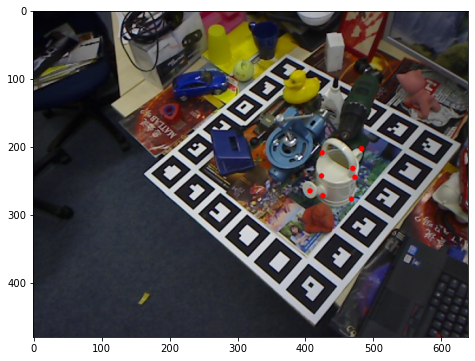

In [3]:
i = 20
meta = dataset.db[i]

imgfile = meta['imgpath']
image = np.array(Image.open(imgfile))

# 6d pose from offical dataset
obj_id = meta['obj_id']
R = meta['R']
t = meta['t']
K = meta['K']

# 3D keypoints for the correspoinding object
obj_kpts3d = np.array(kpts3d[str(obj_id)])

# Projection
kpts_3d = (R @ obj_kpts3d.T).T + t
kpts_2d = (K @ kpts_3d.T).T
kpts_2d = kpts_2d[:,:2]/kpts_2d[:,[2]]

img = draw_kpts(image.copy(), kpts_2d, r=1)

plt.rcParams['figure.figsize'] = 8,6
plt.imshow(img)

[0.09394689 1.5266364 ]
[[ 0.17879259  0.98388679]
 [ 0.98388679 -0.17879259]]
[ 0.98388679 -0.17879259]
-10.299439567858482


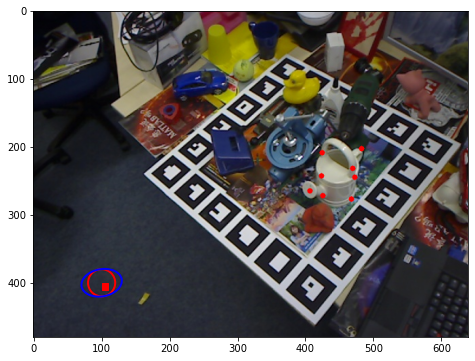

In [26]:
A = np.random.randn(2,2)
A = A @ A.T 
v, V = np.linalg.eig(A)

V = V[:,np.argsort(v)]
v = v[np.argsort(v)]
print(v)
print(V)

Vl = V[:,-1]
print(Vl)
angle = np.arctan2(Vl[-1],Vl[0]) / np.pi * 180
print(angle)


import matplotlib
plt.imshow(img)
ax = plt.gca()
point = plt.Rectangle([100,400],10,10,color='red')
ax.add_patch(point)
circ = plt.Circle((100,400),20,color='red',fill=False,linewidth=2)
ax.add_patch(circ)
ellipse = matplotlib.patches.Ellipse((100,400),60,40,angle=angle,fill=False,color='blue',linewidth=2)
ax.add_patch(ellipse)
plt.show()

### 2D keypoints by dataset class
The previous demo steps are implemented in the BOPDataset class already.

In [12]:
transform_list = [AffineCrop(out_size=256, scale_factor=0., rotation_factor=0, dialation=0.25),
                 LocsToHeatmaps(out_size=(64, 64))]
transform = transforms.Compose(transform_list)

dataset = BOPDataset('data/bop', 'lmo', split='test', 
                     return_keypoints=True, transform=transform,
                     valid_objid=show_objid)

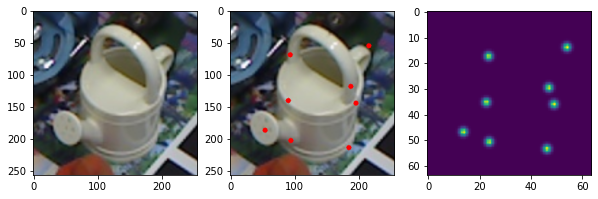

In [13]:
# 2D keypoints are computed by the BOP dataset class
i =20
sample = dataset[i]
img = np.array(sample['image'])

kpts = sample['keypoints']
vis = sample['visible_keypoints'] > 0
kpts_vis = kpts[vis]
img_kpts = draw_kpts(img, kpts_vis, r=1, thickness=5)

vis_heatmaps = sample['keypoint_heatmaps'][:,:,vis]
heatmap = vis_heatmaps.sum(axis=-1)


plt.rcParams['figure.figsize']=10,8
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(img_kpts)
plt.subplot(1,3,3)
plt.imshow(heatmap)

In [15]:
print(vis)
print(kpts)

[ True  True  True  True  True  True  True  True]
[[ 54.59143886 186.97216584   1.        ]
 [ 94.51451576 202.34170254   1.        ]
 [195.11668379 144.04258845   1.        ]
 [ 93.69334727  69.67248656   1.        ]
 [ 90.1658018  140.9888706    1.        ]
 [184.26734471 213.33092502   1.        ]
 [187.13605486 118.38541007   1.        ]
 [215.20815899  55.60028402   1.        ]]


In [31]:
print(vis_heatmaps.shape)
heatmap1 = vis_heatmaps[:,:,2]
print(heatmap1[12,23])
print(np.max(heatmap1))
print(np.min(heatmap1))
print(np.sum(heatmap1))

(64, 64, 8)
3.188531153100349e-270
0.975856808663242
0.0
6.283185346850451
